In [3]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import glob

def load_training_data(data_dir, num_samples=150):
    """
    Load MRI slices and masks from .h5 files
    Returns: images array, masks array
    """
    image_list = []
    mask_list = []

    print("Loading started...")  # ✅ DEBUG LINE
    
    # Get all .h5 files
    files = glob.glob(f'{data_dir}/*.h5')

    if num_samples is not None:
        files = files[:num_samples]
    
    for file_path in files:
        with h5py.File(file_path, 'r') as f:
            image = f['image'][:]
            mask = f['mask'][:]
            
            # Only keep slices with tumor
            if np.sum(mask > 0) > 100:
                # Normalize per-slice
                image = (image - image.min()) / (image.max() - image.min() + 1e-8)
                
                image_list.append(image)
                mask_list.append(mask)
    
    images = np.array(image_list)
    masks = np.array(mask_list)
    
    # Convert masks to binary
    masks = (masks > 0).astype(np.float32)
    
    return images, masks

# Load data
data_dir = './data/BraTS/BraTS2020_training_data/content/data'
X, y = load_training_data(data_dir, num_samples=500)

print(f"Loaded {len(X)} slices")
print(f"Image shape: {X.shape}")
print(f"Mask shape: {y.shape}")

Loading started...
Loaded 200 slices
Image shape: (200, 240, 240, 4)
Mask shape: (200, 240, 240, 3)


In [4]:
# 1. Set seeds at the very top
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers, models
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# 2. Train/Val split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training: {len(X_train)} slices")
print(f"Validation: {len(X_val)} slices")

# 3. Calculate class weights
tumor_pixels = np.sum(y_train)
background_pixels = y_train.size - tumor_pixels
weight_for_tumor = background_pixels / tumor_pixels
print(f"Tumor weight: {weight_for_tumor:.2f}")

# 4. Build model with dropout
def build_unet(input_shape=(240, 240, 4)):
    inputs = layers.Input(input_shape)
    
    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.Dropout(0.1)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.Dropout(0.1)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.Dropout(0.2)(c3)
    
    # Decoder
    u4 = layers.UpSampling2D((2, 2))(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.Dropout(0.1)(c4)
    
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.Dropout(0.1)(c5)
    
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c5)
    
    return models.Model(inputs, outputs)

model = build_unet()

# 5. Define metrics and IMPROVED LOSS
def dice_coef(y_true, y_pred, smooth=1e-5):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Clip predictions to prevent log(0)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    
    # Manual binary crossentropy to maintain shape
    bce = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    focal_weight = alpha * tf.pow(1 - p_t, gamma)
    
    return tf.reduce_mean(focal_weight * bce)

def combined_focal_dice(y_true, y_pred):
    return focal_loss(y_true, y_pred, alpha=0.25, gamma=0.2) + dice_loss(y_true, y_pred)

# 6. Compile with improved loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=combined_focal_dice,
    metrics=[dice_coef]
)

# 7. Create sample weights
sample_weights = np.ones(y_train.shape)
sample_weights[y_train == 1] = weight_for_tumor

# 8. Train with learning rate scheduler
callbacks = [
    EarlyStopping(monitor='val_dice_coef', patience=20, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, patience=5, mode='max', verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_dice_coef', mode='max', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    sample_weight=sample_weights,
    epochs=150,
    batch_size=4,
    callbacks=callbacks,
    verbose=1
)

Training: 160 slices
Validation: 40 slices
Tumor weight: 102.33
Epoch 1/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - dice_coef: 0.0157 - loss: 2.2097

40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 481ms/step - dice_coef: 0.0100 - loss: 2.1655 - val_dice_coef: 2.0983e-05 - val_loss: 1.0299 - learning_rate: 1.0000e-04
Epoch 2/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - dice_coef: 0.0165 - loss: 2.0105

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 471ms/step - dice_coef: 0.0463 - loss: 1.9383 - val_dice_coef: 0.1529 - val_loss: 0.8541 - learning_rate: 1.0000e-04
Epoch 3/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - dice_coef: 0.2180 - loss: 1.5561

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 475ms/step - dice_coef: 0.2553 - loss: 1.4854 - val_dice_coef: 0.2603 - val_loss: 0.7454 - learning_rate: 1.0000e-04
Epoch 4/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - dice_coef: 0.3049 - loss: 1.3798

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 474ms/step - dice_coef: 0.3207 - loss: 1.3550 - val_dice_coef: 0.3484 - val_loss: 0.6580 - learning_rate: 1.0000e-04
Epoch 5/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - dice_coef: 0.3978 - loss: 1.2080

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 473ms/step - dice_coef: 0.4159 - loss: 1.1843 - val_dice_coef: 0.4069 - val_loss: 0.6071 - learning_rate: 1.0000e-04
Epoch 6/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - dice_coef: 0.4213 - loss: 1.1717

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 473ms/step - dice_coef: 0.4361 - loss: 1.1486 - val_dice_coef: 0.4426 - val_loss: 0.5701 - learning_rate: 1.0000e-04
Epoch 7/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - dice_coef: 0.4245 - loss: 1.1646

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 470ms/step - dice_coef: 0.4392 - loss: 1.1414 - val_dice_coef: 0.4434 - val_loss: 0.5700 - learning_rate: 1.0000e-04
Epoch 8/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - dice_coef: 0.4342 - loss: 1.1467

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 477ms/step - dice_coef: 0.4505 - loss: 1.1194 - val_dice_coef: 0.4546 - val_loss: 0.5582 - learning_rate: 1.0000e-04
Epoch 9/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - dice_coef: 0.4403 - loss: 1.1342

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 478ms/step - dice_coef: 0.4558 - loss: 1.1093 - val_dice_coef: 0.4618 - val_loss: 0.5508 - learning_rate: 1.0000e-04
Epoch 10/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - dice_coef: 0.4404 - loss: 1.1341

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 475ms/step - dice_coef: 0.4574 - loss: 1.1063 - val_dice_coef: 0.4649 - val_loss: 0.5474 - learning_rate: 1.0000e-04
Epoch 11/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - dice_coef: 0.4454 - loss: 1.1235

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 476ms/step - dice_coef: 0.4622 - loss: 1.0968 - val_dice_coef: 0.4705 - val_loss: 0.5416 - learning_rate: 1.0000e-04
Epoch 12/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - dice_coef: 0.4484 - loss: 1.1176

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 472ms/step - dice_coef: 0.4655 - loss: 1.0903 - val_dice_coef: 0.4740 - val_loss: 0.5379 - learning_rate: 1.0000e-04
Epoch 13/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - dice_coef: 0.4503 - loss: 1.1133

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 473ms/step - dice_coef: 0.4674 - loss: 1.0864 - val_dice_coef: 0.4787 - val_loss: 0.5329 - learning_rate: 1.0000e-04
Epoch 14/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - dice_coef: 0.4551 - loss: 1.1036

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 470ms/step - dice_coef: 0.4724 - loss: 1.0764 - val_dice_coef: 0.4819 - val_loss: 0.5295 - learning_rate: 1.0000e-04
Epoch 15/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - dice_coef: 0.4577 - loss: 1.0978

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 474ms/step - dice_coef: 0.4767 - loss: 1.0675 - val_dice_coef: 0.4869 - val_loss: 0.5242 - learning_rate: 1.0000e-04
Epoch 16/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - dice_coef: 0.4619 - loss: 1.0887

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 473ms/step - dice_coef: 0.4809 - loss: 1.0588 - val_dice_coef: 0.4919 - val_loss: 0.5188 - learning_rate: 1.0000e-04
Epoch 17/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 472ms/step - dice_coef: 0.4857 - loss: 1.0482 - val_dice_coef: 0.4915 - val_loss: 0.5193 - learning_rate: 1.0000e-04
Epoch 18/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - dice_coef: 0.4742 - loss: 1.0637

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 474ms/step - dice_coef: 0.4913 - loss: 1.0368 - val_dice_coef: 0.4920 - val_loss: 0.5188 - learning_rate: 1.0000e-04
Epoch 19/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - dice_coef: 0.4830 - loss: 1.0460

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 484ms/step - dice_coef: 0.4981 - loss: 1.0226 - val_dice_coef: 0.5080 - val_loss: 0.5023 - learning_rate: 1.0000e-04
Epoch 20/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - dice_coef: 0.4926 - loss: 1.0258

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 467ms/step - dice_coef: 0.5090 - loss: 0.9992 - val_dice_coef: 0.5347 - val_loss: 0.4753 - learning_rate: 1.0000e-04
Epoch 21/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - dice_coef: 0.5123 - loss: 0.9860

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 483ms/step - dice_coef: 0.5295 - loss: 0.9588 - val_dice_coef: 0.5410 - val_loss: 0.4695 - learning_rate: 1.0000e-04
Epoch 22/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - dice_coef: 0.5236 - loss: 0.9645

40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 509ms/step - dice_coef: 0.5386 - loss: 0.9419 - val_dice_coef: 0.5490 - val_loss: 0.4618 - learning_rate: 1.0000e-04
Epoch 23/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - dice_coef: 0.5452 - loss: 0.9189

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 466ms/step - dice_coef: 0.5608 - loss: 0.8944 - val_dice_coef: 0.5905 - val_loss: 0.4184 - learning_rate: 1.0000e-04
Epoch 24/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - dice_coef: 0.5741 - loss: 0.8561

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 474ms/step - dice_coef: 0.5882 - loss: 0.8369 - val_dice_coef: 0.6070 - val_loss: 0.4020 - learning_rate: 1.0000e-04
Epoch 25/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - dice_coef: 0.5934 - loss: 0.8184

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 470ms/step - dice_coef: 0.5987 - loss: 0.8168 - val_dice_coef: 0.6130 - val_loss: 0.3965 - learning_rate: 1.0000e-04
Epoch 26/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - dice_coef: 0.5925 - loss: 0.8193

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 476ms/step - dice_coef: 0.5996 - loss: 0.8133 - val_dice_coef: 0.6184 - val_loss: 0.3908 - learning_rate: 1.0000e-04
Epoch 27/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - dice_coef: 0.6035 - loss: 0.7980

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 471ms/step - dice_coef: 0.6080 - loss: 0.7976 - val_dice_coef: 0.6189 - val_loss: 0.3907 - learning_rate: 1.0000e-04
Epoch 28/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 471ms/step - dice_coef: 0.6083 - loss: 0.7973 - val_dice_coef: 0.6106 - val_loss: 0.3995 - learning_rate: 1.0000e-04
Epoch 29/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 469ms/step - dice_coef: 0.6099 - loss: 0.7953 - val_dice_coef: 0.6019 - val_loss: 0.4089 - learning_rate: 1.0000e-04
Epoch 30/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 467ms/step - dice_coef: 0.6127 - loss: 0.7896 - val_dice_coef: 0.6020 - val_loss: 0.4090 - learning_rate: 1.0000e-04
Epoch 31/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 470ms/step - dice_coef: 0.6173 - loss: 0.7795 - val_dice_coef: 0.6156 - val_loss: 0.3947 - learning_rate: 1.0000e-04
Epoch 32/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - dice_coef: 0.6185 - loss: 0.7690

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 471ms/step - dice_coef: 0.6273 - loss: 0.7584 - val_dice_coef: 0.6295 - val_loss: 0.3801 - learning_rate: 1.0000e-04
Epoch 33/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - dice_coef: 0.6308 - loss: 0.7425

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 469ms/step - dice_coef: 0.6374 - loss: 0.7371 - val_dice_coef: 0.6369 - val_loss: 0.3724 - learning_rate: 1.0000e-04
Epoch 34/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - dice_coef: 0.6405 - loss: 0.7230

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 474ms/step - dice_coef: 0.6453 - loss: 0.7209 - val_dice_coef: 0.6402 - val_loss: 0.3691 - learning_rate: 1.0000e-04
Epoch 35/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - dice_coef: 0.6453 - loss: 0.7132

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 468ms/step - dice_coef: 0.6507 - loss: 0.7102 - val_dice_coef: 0.6459 - val_loss: 0.3633 - learning_rate: 1.0000e-04
Epoch 36/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - dice_coef: 0.6481 - loss: 0.7069

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 469ms/step - dice_coef: 0.6530 - loss: 0.7050 - val_dice_coef: 0.6472 - val_loss: 0.3620 - learning_rate: 1.0000e-04
Epoch 37/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - dice_coef: 0.6530 - loss: 0.6973

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 473ms/step - dice_coef: 0.6575 - loss: 0.6962 - val_dice_coef: 0.6523 - val_loss: 0.3568 - learning_rate: 1.0000e-04
Epoch 38/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - dice_coef: 0.6560 - loss: 0.6910

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 469ms/step - dice_coef: 0.6605 - loss: 0.6896 - val_dice_coef: 0.6565 - val_loss: 0.3525 - learning_rate: 1.0000e-04
Epoch 39/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - dice_coef: 0.6602 - loss: 0.6825

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 467ms/step - dice_coef: 0.6637 - loss: 0.6832 - val_dice_coef: 0.6569 - val_loss: 0.3523 - learning_rate: 1.0000e-04
Epoch 40/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - dice_coef: 0.6608 - loss: 0.6808

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 466ms/step - dice_coef: 0.6649 - loss: 0.6807 - val_dice_coef: 0.6587 - val_loss: 0.3505 - learning_rate: 1.0000e-04
Epoch 41/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - dice_coef: 0.6650 - loss: 0.6726

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 470ms/step - dice_coef: 0.6683 - loss: 0.6739 - val_dice_coef: 0.6646 - val_loss: 0.3443 - learning_rate: 1.0000e-04
Epoch 42/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - dice_coef: 0.6680 - loss: 0.6661

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 473ms/step - dice_coef: 0.6706 - loss: 0.6689 - val_dice_coef: 0.6672 - val_loss: 0.3416 - learning_rate: 1.0000e-04
Epoch 43/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - dice_coef: 0.6689 - loss: 0.6638

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 470ms/step - dice_coef: 0.6707 - loss: 0.6683 - val_dice_coef: 0.6693 - val_loss: 0.3395 - learning_rate: 1.0000e-04
Epoch 44/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 470ms/step - dice_coef: 0.6667 - loss: 0.6756 - val_dice_coef: 0.6683 - val_loss: 0.3406 - learning_rate: 1.0000e-04
Epoch 45/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 471ms/step - dice_coef: 0.6620 - loss: 0.6847 - val_dice_coef: 0.6545 - val_loss: 0.3551 - learning_rate: 1.0000e-04
Epoch 46/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 469ms/step - dice_coef: 0.6573 - loss: 0.6955 - val_dice_coef: 0.6295 - val_loss: 0.3813 - learning_rate: 1.0000e-04
Epoch 47/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 471ms/step - dice_coef: 0.6614 - loss: 0.6885 - val_dice_coef: 0.6247 - val_loss: 0.3862 - learning_rate: 1.0000e-04
Epoch 48/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - dice_coef: 0.6693 - loss: 0.6673
Epoch 48: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 468ms/step 

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 469ms/step - dice_coef: 0.6886 - loss: 0.6338 - val_dice_coef: 0.6803 - val_loss: 0.3272 - learning_rate: 5.0000e-05
Epoch 50/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 472ms/step - dice_coef: 0.6926 - loss: 0.6252 - val_dice_coef: 0.6715 - val_loss: 0.3368 - learning_rate: 5.0000e-05
Epoch 51/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 470ms/step - dice_coef: 0.6963 - loss: 0.6179 - val_dice_coef: 0.6779 - val_loss: 0.3301 - learning_rate: 5.0000e-05
Epoch 52/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 475ms/step - dice_coef: 0.6986 - loss: 0.6127 - val_dice_coef: 0.6748 - val_loss: 0.3334 - learning_rate: 5.0000e-05
Epoch 53/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 471ms/step - dice_coef: 0.7003 - loss: 0.6094 - val_dice_coef: 0.6766 - val_loss: 0.3316 - learning_rate: 5.0000e-05
Epoch 54/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - dice_coef: 0.7042 - loss: 0.5956
Epoch 54: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 472ms/step 

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 470ms/step - dice_coef: 0.7072 - loss: 0.5952 - val_dice_coef: 0.6936 - val_loss: 0.3133 - learning_rate: 2.5000e-05
Epoch 56/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - dice_coef: 0.7062 - loss: 0.5901

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 476ms/step - dice_coef: 0.7069 - loss: 0.5953 - val_dice_coef: 0.6952 - val_loss: 0.3117 - learning_rate: 2.5000e-05
Epoch 57/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - dice_coef: 0.7089 - loss: 0.5845

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 474ms/step - dice_coef: 0.7089 - loss: 0.5912 - val_dice_coef: 0.6961 - val_loss: 0.3107 - learning_rate: 2.5000e-05
Epoch 58/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - dice_coef: 0.7096 - loss: 0.5828

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 471ms/step - dice_coef: 0.7101 - loss: 0.5887 - val_dice_coef: 0.6969 - val_loss: 0.3099 - learning_rate: 2.5000e-05
Epoch 59/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - dice_coef: 0.7099 - loss: 0.5822

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 478ms/step - dice_coef: 0.7115 - loss: 0.5855 - val_dice_coef: 0.6980 - val_loss: 0.3088 - learning_rate: 2.5000e-05
Epoch 60/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - dice_coef: 0.7108 - loss: 0.5806

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 476ms/step - dice_coef: 0.7125 - loss: 0.5839 - val_dice_coef: 0.6987 - val_loss: 0.3081 - learning_rate: 2.5000e-05
Epoch 61/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - dice_coef: 0.7134 - loss: 0.5752

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 470ms/step - dice_coef: 0.7143 - loss: 0.5801 - val_dice_coef: 0.6998 - val_loss: 0.3070 - learning_rate: 2.5000e-05
Epoch 62/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 471ms/step - dice_coef: 0.7152 - loss: 0.5781 - val_dice_coef: 0.6997 - val_loss: 0.3071 - learning_rate: 2.5000e-05
Epoch 63/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - dice_coef: 0.7155 - loss: 0.5710

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 470ms/step - dice_coef: 0.7164 - loss: 0.5757 - val_dice_coef: 0.7006 - val_loss: 0.3062 - learning_rate: 2.5000e-05
Epoch 64/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - dice_coef: 0.7164 - loss: 0.5695

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 470ms/step - dice_coef: 0.7178 - loss: 0.5727 - val_dice_coef: 0.7012 - val_loss: 0.3056 - learning_rate: 2.5000e-05
Epoch 65/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - dice_coef: 0.7167 - loss: 0.5687

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 471ms/step - dice_coef: 0.7187 - loss: 0.5711 - val_dice_coef: 0.7022 - val_loss: 0.3046 - learning_rate: 2.5000e-05
Epoch 66/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - dice_coef: 0.7179 - loss: 0.5665

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 475ms/step - dice_coef: 0.7198 - loss: 0.5689 - val_dice_coef: 0.7029 - val_loss: 0.3038 - learning_rate: 2.5000e-05
Epoch 67/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - dice_coef: 0.7181 - loss: 0.5655

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 465ms/step - dice_coef: 0.7204 - loss: 0.5674 - val_dice_coef: 0.7035 - val_loss: 0.3033 - learning_rate: 2.5000e-05
Epoch 68/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 469ms/step - dice_coef: 0.7226 - loss: 0.5629 - val_dice_coef: 0.7030 - val_loss: 0.3039 - learning_rate: 2.5000e-05
Epoch 69/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - dice_coef: 0.7223 - loss: 0.5575

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 469ms/step - dice_coef: 0.7235 - loss: 0.5610 - val_dice_coef: 0.7044 - val_loss: 0.3023 - learning_rate: 2.5000e-05
Epoch 70/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 467ms/step - dice_coef: 0.7254 - loss: 0.5574 - val_dice_coef: 0.7042 - val_loss: 0.3026 - learning_rate: 2.5000e-05
Epoch 71/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - dice_coef: 0.7239 - loss: 0.5543

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 465ms/step - dice_coef: 0.7254 - loss: 0.5570 - val_dice_coef: 0.7046 - val_loss: 0.3022 - learning_rate: 2.5000e-05
Epoch 72/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - dice_coef: 0.7251 - loss: 0.5519

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 468ms/step - dice_coef: 0.7267 - loss: 0.5547 - val_dice_coef: 0.7059 - val_loss: 0.3008 - learning_rate: 2.5000e-05
Epoch 73/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 468ms/step - dice_coef: 0.7275 - loss: 0.5527 - val_dice_coef: 0.7053 - val_loss: 0.3014 - learning_rate: 2.5000e-05
Epoch 74/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - dice_coef: 0.7270 - loss: 0.5481

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 467ms/step - dice_coef: 0.7284 - loss: 0.5511 - val_dice_coef: 0.7060 - val_loss: 0.3008 - learning_rate: 2.5000e-05
Epoch 75/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - dice_coef: 0.7279 - loss: 0.5463

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 479ms/step - dice_coef: 0.7294 - loss: 0.5492 - val_dice_coef: 0.7072 - val_loss: 0.2995 - learning_rate: 2.5000e-05
Epoch 76/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 472ms/step - dice_coef: 0.7299 - loss: 0.5478 - val_dice_coef: 0.7064 - val_loss: 0.3003 - learning_rate: 2.5000e-05
Epoch 77/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 466ms/step - dice_coef: 0.7316 - loss: 0.5444 - val_dice_coef: 0.7069 - val_loss: 0.2998 - learning_rate: 2.5000e-05
Epoch 78/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - dice_coef: 0.7308 - loss: 0.5405

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 472ms/step - dice_coef: 0.7323 - loss: 0.5430 - val_dice_coef: 0.7083 - val_loss: 0.2984 - learning_rate: 2.5000e-05
Epoch 79/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - dice_coef: 0.7317 - loss: 0.5382

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 476ms/step - dice_coef: 0.7333 - loss: 0.5406 - val_dice_coef: 0.7086 - val_loss: 0.2981 - learning_rate: 2.5000e-05
Epoch 80/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - dice_coef: 0.7336 - loss: 0.5346

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 479ms/step - dice_coef: 0.7346 - loss: 0.5382 - val_dice_coef: 0.7088 - val_loss: 0.2980 - learning_rate: 2.5000e-05
Epoch 81/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - dice_coef: 0.7339 - loss: 0.5341

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 468ms/step - dice_coef: 0.7354 - loss: 0.5367 - val_dice_coef: 0.7094 - val_loss: 0.2973 - learning_rate: 2.5000e-05
Epoch 82/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 470ms/step - dice_coef: 0.7361 - loss: 0.5353 - val_dice_coef: 0.7088 - val_loss: 0.2980 - learning_rate: 2.5000e-05
Epoch 83/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - dice_coef: 0.7354 - loss: 0.5313

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 468ms/step - dice_coef: 0.7370 - loss: 0.5333 - val_dice_coef: 0.7102 - val_loss: 0.2966 - learning_rate: 2.5000e-05
Epoch 84/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - dice_coef: 0.7389 - loss: 0.5243

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 469ms/step - dice_coef: 0.7393 - loss: 0.5286 - val_dice_coef: 0.7102 - val_loss: 0.2965 - learning_rate: 2.5000e-05
Epoch 85/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - dice_coef: 0.7375 - loss: 0.5266

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 473ms/step - dice_coef: 0.7391 - loss: 0.5289 - val_dice_coef: 0.7103 - val_loss: 0.2964 - learning_rate: 2.5000e-05
Epoch 86/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - dice_coef: 0.7394 - loss: 0.5232

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 473ms/step - dice_coef: 0.7401 - loss: 0.5268 - val_dice_coef: 0.7108 - val_loss: 0.2959 - learning_rate: 2.5000e-05
Epoch 87/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - dice_coef: 0.7390 - loss: 0.5236

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 469ms/step - dice_coef: 0.7402 - loss: 0.5267 - val_dice_coef: 0.7116 - val_loss: 0.2951 - learning_rate: 2.5000e-05
Epoch 88/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - dice_coef: 0.7409 - loss: 0.5200

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 468ms/step - dice_coef: 0.7418 - loss: 0.5235 - val_dice_coef: 0.7123 - val_loss: 0.2943 - learning_rate: 2.5000e-05
Epoch 89/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 470ms/step - dice_coef: 0.7426 - loss: 0.5219 - val_dice_coef: 0.7117 - val_loss: 0.2951 - learning_rate: 2.5000e-05
Epoch 90/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - dice_coef: 0.7417 - loss: 0.5181

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 485ms/step - dice_coef: 0.7432 - loss: 0.5203 - val_dice_coef: 0.7123 - val_loss: 0.2944 - learning_rate: 2.5000e-05
Epoch 91/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 472ms/step - dice_coef: 0.7441 - loss: 0.5185 - val_dice_coef: 0.7121 - val_loss: 0.2946 - learning_rate: 2.5000e-05
Epoch 92/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - dice_coef: 0.7441 - loss: 0.5138

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 472ms/step - dice_coef: 0.7449 - loss: 0.5171 - val_dice_coef: 0.7129 - val_loss: 0.2939 - learning_rate: 2.5000e-05
Epoch 93/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - dice_coef: 0.7449 - loss: 0.5121

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 488ms/step - dice_coef: 0.7454 - loss: 0.5162 - val_dice_coef: 0.7145 - val_loss: 0.2921 - learning_rate: 2.5000e-05
Epoch 94/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 472ms/step - dice_coef: 0.7466 - loss: 0.5138 - val_dice_coef: 0.7125 - val_loss: 0.2943 - learning_rate: 2.5000e-05
Epoch 95/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - dice_coef: 0.7463 - loss: 0.5096

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 478ms/step - dice_coef: 0.7465 - loss: 0.5140 - val_dice_coef: 0.7147 - val_loss: 0.2920 - learning_rate: 2.5000e-05
Epoch 96/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 473ms/step - dice_coef: 0.7486 - loss: 0.5096 - val_dice_coef: 0.7144 - val_loss: 0.2923 - learning_rate: 2.5000e-05
Epoch 97/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 472ms/step - dice_coef: 0.7486 - loss: 0.5095 - val_dice_coef: 0.7125 - val_loss: 0.2944 - learning_rate: 2.5000e-05
Epoch 98/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - dice_coef: 0.7488 - loss: 0.5046

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 475ms/step - dice_coef: 0.7487 - loss: 0.5094 - val_dice_coef: 0.7165 - val_loss: 0.2901 - learning_rate: 2.5000e-05
Epoch 99/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 475ms/step - dice_coef: 0.7500 - loss: 0.5068 - val_dice_coef: 0.7148 - val_loss: 0.2920 - learning_rate: 2.5000e-05
Epoch 100/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 472ms/step - dice_coef: 0.7506 - loss: 0.5057 - val_dice_coef: 0.7156 - val_loss: 0.2912 - learning_rate: 2.5000e-05
Epoch 101/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 473ms/step - dice_coef: 0.7519 - loss: 0.5029 - val_dice_coef: 0.7151 - val_loss: 0.2918 - learning_rate: 2.5000e-05
Epoch 102/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 471ms/step - dice_coef: 0.7517 - loss: 0.5031 - val_dice_coef: 0.7161 - val_loss: 0.2906 - learning_rate: 2.5000e-05
Epoch 103/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - dice_coef: 0.7528 - loss: 0.4962
Epoch 103: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 471ms/

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 471ms/step - dice_coef: 0.7539 - loss: 0.4978 - val_dice_coef: 0.7173 - val_loss: 0.2891 - learning_rate: 1.2500e-05
Epoch 106/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 472ms/step - dice_coef: 0.7562 - loss: 0.4938 - val_dice_coef: 0.7172 - val_loss: 0.2892 - learning_rate: 1.2500e-05
Epoch 107/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - dice_coef: 0.7549 - loss: 0.4911

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 477ms/step - dice_coef: 0.7553 - loss: 0.4953 - val_dice_coef: 0.7183 - val_loss: 0.2881 - learning_rate: 1.2500e-05
Epoch 108/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 473ms/step - dice_coef: 0.7560 - loss: 0.4940 - val_dice_coef: 0.7172 - val_loss: 0.2892 - learning_rate: 1.2500e-05
Epoch 109/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 478ms/step - dice_coef: 0.7557 - loss: 0.4945 - val_dice_coef: 0.7175 - val_loss: 0.2890 - learning_rate: 1.2500e-05
Epoch 110/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 470ms/step - dice_coef: 0.7567 - loss: 0.4925 - val_dice_coef: 0.7175 - val_loss: 0.2890 - learning_rate: 1.2500e-05
Epoch 111/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 475ms/step - dice_coef: 0.7574 - loss: 0.4908 - val_dice_coef: 0.7169 - val_loss: 0.2896 - learning_rate: 1.2500e-05
Epoch 112/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - dice_coef: 0.7563 - loss: 0.4880
Epoch 112: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 474ms/

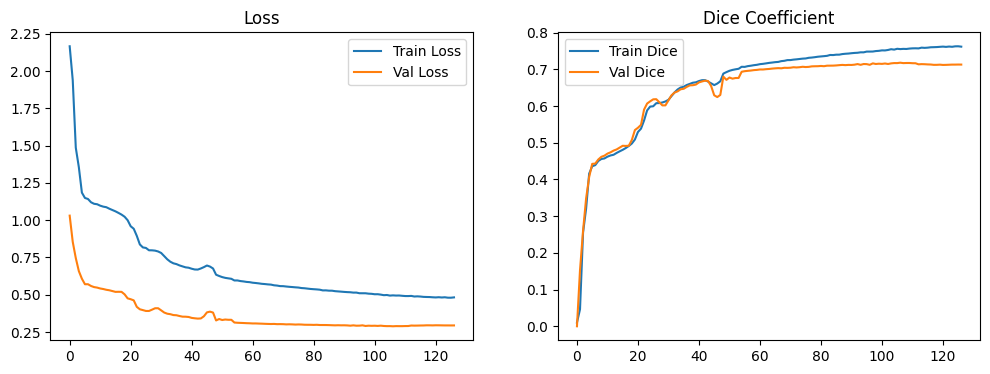

In [5]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Val Dice')
plt.legend()
plt.title('Dice Coefficient')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 399ms/step


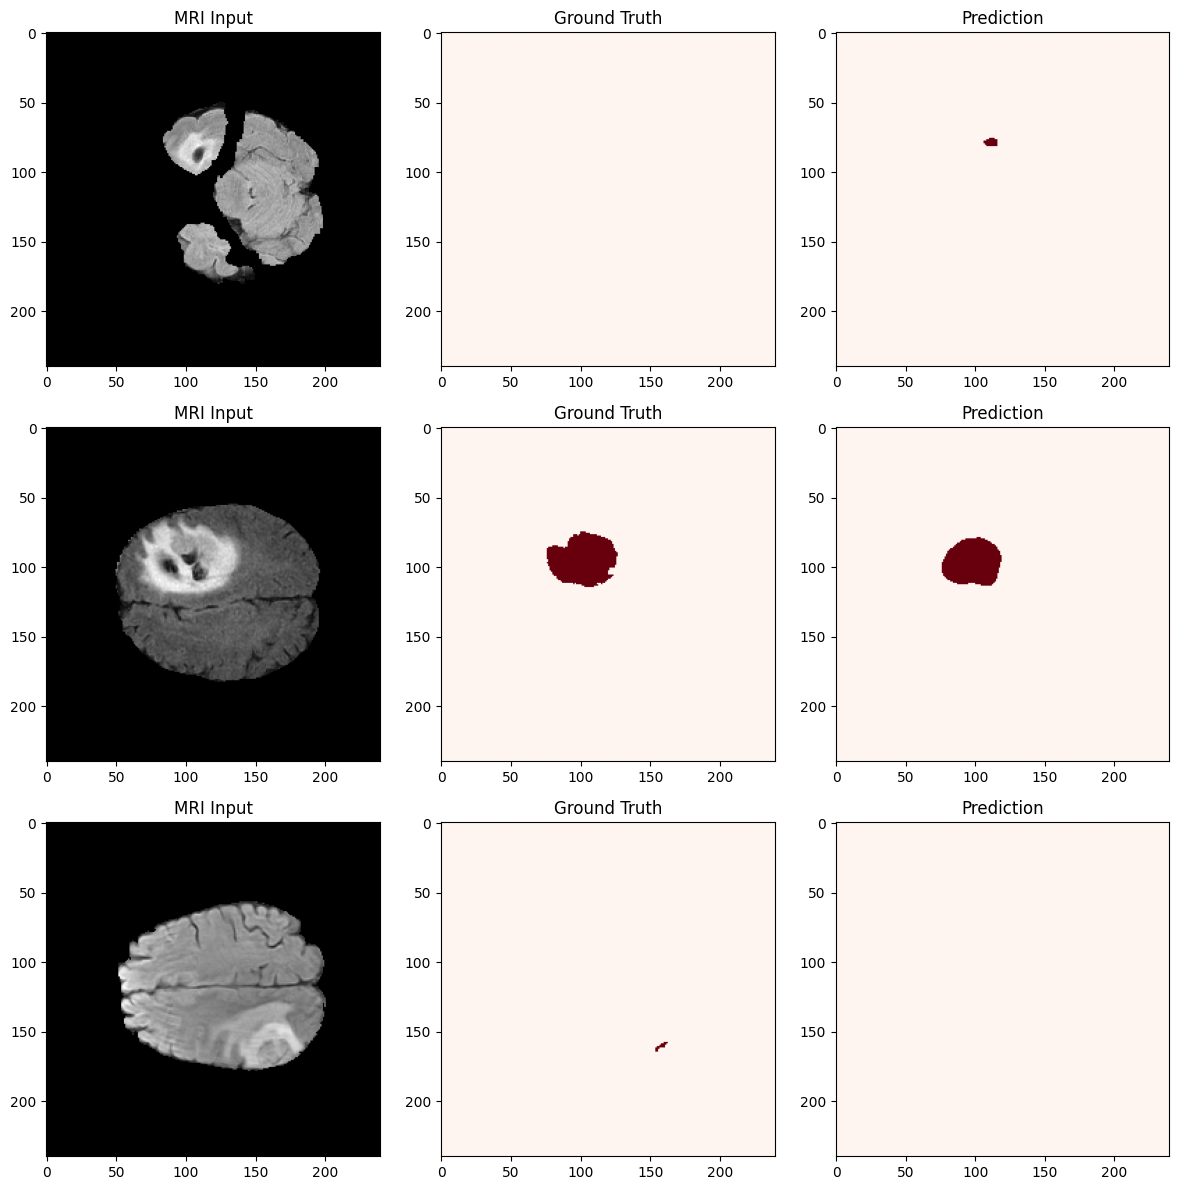

In [6]:
# Predict on validation set
predictions = model.predict(X_val)

# Visualize
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i in range(3):
    axes[i, 0].imshow(X_val[i, :, :, 0], cmap='gray')
    axes[i, 0].set_title('MRI Input')
    
    axes[i, 1].imshow(y_val[i, :, :, 0], cmap='Reds')
    axes[i, 1].set_title('Ground Truth')
    
    axes[i, 2].imshow(predictions[i, :, :, 0] > 0.5, cmap='Reds')
    axes[i, 2].set_title('Prediction')

plt.tight_layout()
plt.show()